# Modeling Transmission Line Properties
## Table of Contents
* [Introduction](#introduction)
 * [Propagation constant](#propagation_constant)
 * [Interlude on attenuation units](#attenuation_units)
* [Modeling a loaded lossy transmission line using transmission line functions](#tline_functions)
 * [Input impedances, reflection coefficients and SWR](#tline_impedances)
 * [Voltages and Currents](#voltages_currents)
* [Modeling a loaded lossy transmission line by cascading Networks](#cascading_networks)
* [Determination of the propagation constant from the input impedance](#propagation_constant_from_zin)


## Introduction <a class="anchor" id="introduction"></a>
In this tutorial, `scikit-rf` is used to work with some classical transmission line situations, such as calculating impedances, reflection coefficients, standing wave ratios or voltages and currents. There is at least two way of performing these calculations, one using [transmission line functions](#tline_functions) or by [creating and cascading Networks](#cascading_networks)

Let's consider a lossy coaxial cable of characteristic impedance $Z_0=75 \Omega$ of length $d=12 m$. The coaxial cable has an attenuation of 0.02 Neper/m and a [velocity factor](https://en.wikipedia.org/wiki/Velocity_factor) VF=0.67 (This corresponds roughly to a [RG-6](https://en.wikipedia.org/wiki/RG-6) coaxial). The cable is loaded with a $Z_L=150 \Omega$ impedance. The RF frequency of interest is 250 MHz. 

Please note that in `scikit-rf`, the line length is defined from the load, ie $z=0$ at the load and $z=d$ at the input of the transmission line:
<img src="transmission_line_properties.svg">


First, let's make the necessary Python import statements:

In [1]:
%matplotlib inline
import skrf as rf 
from pylab import * 

In [2]:
# skrf figure styling
rf.stylely()

And the constants of the problem:

In [3]:
freq = rf.Frequency(250, npoints=1, unit='MHz')
Z_0 = 75  # Ohm
Z_L = 150  # Ohm
d = 12  # m
VF = 0.67
att = 0.02 # Np/m. Equivalent to 0.1737 dB/m

Before going into impedance and reflection coefficient calculations, first we need to define the transmission line properties, in particular its propagation constant.

### Propagation constant <a class="anchor" id="propagation_constant"></a>
In order to get the RF parameters of the transmission line, it is necessary to derive the propagation constant of the line. The propagation constant $\gamma$ of the line is defined in `scikit-rf` as $\gamma=\alpha + j\beta$ where $\alpha$ is the attenuation (in Neper/m) and $\beta=\frac{2\pi}{\lambda}=\frac{\omega}{c}/\mathrm{VF}=\frac{\omega}{c}\sqrt{\epsilon_r}$ the phase constant.

First, the wavelength in the coaxial cable is $$\lambda=\frac{c}{f \sqrt{\epsilon_r}}=\frac{c}{f} \mathrm{VF} $$ 

In [4]:
lambd = rf.c/freq.f * VF
print('VF=', VF, 'and Wavelength:', lambd, 'm')

VF= 0.67 and Wavelength: [0.80344379] m


As the attenuation is already given in Np/m, the propagation constant is:

In [5]:
alpha = att  # Np/m !
beta = freq.w/rf.c/VF
gamma = alpha + 1j*beta
print('Transmission line propagation constant: gamma = ', gamma, 'rad/m')

Transmission line propagation constant: gamma =  [0.02+7.82031725j] rad/m


If the attenuation would have been given in other units, `scikit-rf` provides the necessary tools to convert units, as described below.

### Interlude: On Attenuation Units <a class="anchor" id="attenuation_units"></a>

Attenuation is generally provided (or expected) in various kind of units. `scikit-rf` provides convenience functions to manipulate line attenuation units. 

For example, the cable attenuation given in Np/m, can be expressed in dB:

In [6]:
print('Attenuation dB/m:', rf.np_2_db(att))

Attenuation dB/m: 0.1737177927613007


Hence, the attenuation in dB/100m is:

In [7]:
print('Line attenuation in dB/100m:', rf.np_2_db(att)*100)

Line attenuation in dB/100m: 17.37177927613007


And in dB/100feet is:

In [8]:
print('Line attenuation in dB/100ft:', rf.np_2_db(att)*100*rf.feet_2_meter())

Line attenuation in dB/100ft: 5.2949183233644455


If the attenuation would have been given in imperial units, such as dB/100ft, the opposite conversions would have been: 

In [9]:
rf.db_per_100feet_2_db_per_100meter(5.2949)  # to dB/100m

17.371719160104988

In [10]:
rf.db_2_np(5.2949)/rf.feet_2_meter(100)  # to Np/m

0.019999930788868397

## Using transmission line functions <a class="anchor" id="tline_functions"></a>
`scikit-rf` brings few convenient functions to deal with transmission lines. They are detailed in the [transmission line functions](https://scikit-rf.readthedocs.io/en/latest/api/tlineFunctions.html) documentation pages. 

### Input impedances, reflection coefficients and SWR <a class="anchor" id="tline_impedances"></a>
The reflection coefficient $\Gamma_L$ induced by the load is given by `zl_2_Gamma0()`:

In [11]:
Gamma0 = rf.zl_2_Gamma0(Z_0, Z_L)
print('|Gamma0|=', abs(Gamma0))

|Gamma0|= [0.33333333]


and its associated Standing Wave Ratio (SWR) is obtained from `zl_2_swr()`:

In [12]:
rf.zl_2_swr(Z_0, Z_L)

array([2.])

After propagating by a distance $d$ in the transmission line of propagation constant $\gamma$ (hence having travelled an electrical length $\theta=\gamma d$), the reflection coefficient at the line input is obtained from `zl_2_Gamma_in()`:

In [13]:
Gamma_in = rf.zl_2_Gamma_in(Z_0, Z_L, theta=gamma*d)
print('|Gamma_in|=', abs(Gamma_in), 'phase=', 180/rf.pi*angle(Gamma_in))

|Gamma_in|= [0.20626113] phase= [46.2918563]


The input impedance $Z_{in}$ from `zl_2_zin()`:

In [14]:
Z_in = rf.zl_2_zin(Z_0, Z_L, gamma * d)
print('Input impedance Z_in=', Z_in)

Input impedance Z_in= [94.79804694+29.52482706j]


Like previously, the SWR at the line input is:

In [15]:
rf.zl_2_swr(Z_0, Z_in)

array([1.51972037])

The total line loss in dB is get from `zl_2_total_loss()`:

In [16]:
rf.mag_2_db10(rf.zl_2_total_loss(Z_0, Z_L, gamma*d))

array([2.40732856])

### Voltages and Currents <a class="anchor" id="voltages_currents"></a>

Now assume that the previous circuit is excited by a source delivering a voltage $V=1 V$ associated to a source impedance $Z_s=100\Omega$ :
<img src="transmission_line_properties_vi.svg">

In [17]:
Z_s = 100  # Ohm
V_s = 1  # V

At the input of the transmission line, the voltage is a voltage divider circuit:
$$
V_{in} = V_s  \frac{Z_{in}}{Z_s + Z_{in}}
$$

In [18]:
V_in = V_s * Z_in / (Z_s + Z_in)
print('Voltage at transmission line input : V_in = ', V_in, ' V')

Voltage at transmission line input : V_in =  [0.49817591+0.07605964j]  V


and the current at the input of the transmission line is:
$$
I_{in} = \frac{V_s}{Z_s + Z_{in}}
$$

In [19]:
I_in = V_s / (Z_s + Z_in)
print('Current at transmission line input : I_in = ', I_in, ' A')

Current at transmission line input : I_in =  [0.00501824-0.0007606j]  A


which represent a power of 
$$
P_{in} = \frac{1}{2} \Re \left[V_{in} I_{in}^* \right]
$$

In [20]:
P_in = 1/2 * real(V_in * conj(I_in))
print('Input Power : P_in = ', P_in, 'W')

Input Power : P_in =  [0.00122106] W


The reflected power is:
$$
P_r = |\Gamma_{in}|^2 P_{in}
$$

In [21]:
P_r = abs(Gamma_in)**2 * P_in
print('Reflected power : P_r = ', P_r, 'W')

Reflected power : P_r =  [5.19482699e-05] W


The voltage and current at the load can be deduced from the ABCD parameters of the line of length $L$ :

In [22]:
V_out, I_out = rf.voltage_current_propagation(V_in, I_in, Z_0,theta= gamma*d)
print('Voltage at load: V_out = ', V_out, 'V')
print('Current at load: I_out = ', I_out, 'A')

Voltage at load: V_out =  [0.41779105+0.18944365j] V
Current at load: I_out =  [0.00278527+0.00126296j] A


Note that voltages and currents are expressed a peak values. RMS values are thus:


In [23]:
print(abs(V_out)/sqrt(2), abs(I_out)/sqrt(2))

[0.32437498] [0.0021625]


The power delivered to the load is thus:

In [24]:
P_out = 1/2 * real(V_out * conj(I_out))
print('Power delivered to the load : P_out = ', P_out, ' W')

Power delivered to the load : P_out =  [0.00070146]  W


Voltage and current are plotted below against the transmission line length (pay attention to the sign of $d$ in the voltage and current propagation: as we go from source ($z=d$) to the load ($z=0$), $\theta$ goes in the opposite direction and should be inversed)

In [25]:
ds = linspace(0, d, num=1001)

thetas = - gamma*ds 

v1 = np.full_like(ds, V_in)
i1 = np.full_like(ds, I_in)

v2, i2 = rf.voltage_current_propagation(v1, i1, Z_0, thetas)

<__array_function__ internals>:5: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0.5, 1.0, 'Voltage')

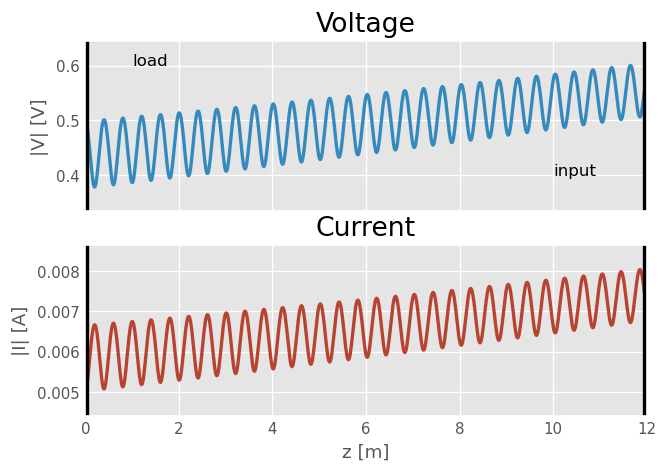

In [26]:
fig, (ax_V, ax_I) = plt.subplots(2, 1, sharex=True)
ax_V.plot(ds, abs(v2), lw=2)
ax_I.plot(ds, abs(i2), lw=2, c='C1')
ax_I.set_xlabel('z [m]')
ax_V.set_ylabel('|V| [V]')
ax_I.set_ylabel('|I| [A]')


ax_V.axvline(0, c='k', lw=5)
ax_I.axvline(0, c='k', lw=5)
ax_V.text(d-2, 0.4, 'input')
ax_V.text(1, 0.6, 'load')
ax_V.axvline(d, c='k', lw=5)
ax_I.axvline(d, c='k', lw=5)

ax_I.set_title('Current')
ax_V.set_title('Voltage')

## Using `media` objects for transmission line calculations <a class="anchor" id="cascading_networks"></a>

`scikit-rf` also provides objects representing transmission line mediums. The `Media` object provides generic methods to produce Network’s for any transmission line medium, such as transmission line length (`line()`), lumped components (`resistor()`, `capacitor()`, `inductor()`, `shunt()`, etc.) or terminations (`open()`, `short()`, `load()`). For additional references, please see the [media documentation](https://scikit-rf.readthedocs.io/en/latest/api/media/). 

Let's create a transmission line `media` object for our coaxial line of characteristic impedance $Z_0$ and propagation constant $\gamma$:

In [27]:
# if not passing the gamma parameter, it would assume that gamma = alpha + j*beta = 0 + j*1
coax_line = rf.media.DefinedGammaZ0(frequency=freq, Z0=Z_0, gamma=gamma)

In order to build the circuit illustrated by the figure above, all the circuit's Networks are created and then [cascaded](https://scikit-rf.readthedocs.io/en/latest/tutorials/Networks.html#Cascading-and-De-embedding) with the `**` operator: 

<img src="transmission_line_properties_networks.svg">

 * [transmission line](https://scikit-rf.readthedocs.io/en/latest/api/media/generated/skrf.media.media.Media.line.html) of length $d$ (from the media created above), 
 * a [resistor](https://scikit-rf.readthedocs.io/en/latest/api/media/generated/skrf.media.media.Media.resistor.html) of impedance $Z_L$, 
 * then terminated by a [short](https://scikit-rf.readthedocs.io/en/latest/api/media/generated/skrf.media.media.Media.short.html). 

This results in a one-port network, which $Z$-parameter is then the input impedance: 

In [28]:
ntw = coax_line.line(d, unit='m') ** coax_line.resistor(Z_L) ** coax_line.short()
ntw.z

array([[[94.79804694+29.52482706j]]])

Note that full Network can also be built with convenience functions [load](https://scikit-rf.readthedocs.io/en/latest/api/media/generated/skrf.media.media.Media.load.html):

In [29]:
ntw = coax_line.line(d, unit='m') ** coax_line.load(rf.zl_2_Gamma0(Z_0, Z_L))
ntw.z

array([[[94.79804694+29.52482706j]]])

or even more directly using or [delay_load](https://scikit-rf.readthedocs.io/en/latest/api/media/generated/skrf.media.media.Media.delay_load.html):

In [30]:
ntw = coax_line.delay_load(rf.zl_2_Gamma0(Z_0, Z_L), d, unit='m')
ntw.z

array([[[94.79804694+29.52482706j]]])

## Determination of the propagation constant from the input impedance  <a class="anchor" id="propagation_constant_from_zin"></a>
Let's assume the input impedance of a short‐circuited lossy transmission line of length d=1.5 m and a characteristic impedance of $Z_0=$100 Ohm has been measured to $Z_{in}=40 - 280j \Omega$. 

<img src="transmission_line_properties_propagation_constant.svg">

The transmission line propagation constant $\gamma$ is unknown and researched. Let see how to deduce its value  using `scikit-rf`:

In [31]:
# input data
z_in = 20 - 140j
z_0 = 75
d = 1.5
Gamma_load = -1 # short

Since we know the input impedance, we can deduce the reflection coefficient at the input of the transmission line. Since there is a direction relationship between the reflection coefficient at the load and at the input of the line:

$$
\Gamma_{in} = \Gamma_L e^{- 2 \gamma d}
$$

we can deduce the propagation constant value $\gamma$ as:
$$
\gamma = -\frac{1}{2d} \ln \left( \frac{\Gamma_{in}}{\Gamma_l} \right)
$$

This is what the convenience function `reflection_coefficient_2_propagation_constant` is doing:

In [32]:
# reflection coefficient at input
Gamma_in = rf.zl_2_Gamma0(z_0, z_in)
# line propagation constant
gamma = rf.reflection_coefficient_2_propagation_constant(Gamma_in, Gamma_load, d)
print('Line propagation constant, gamma =', gamma, 'rad/m')

Line propagation constant, gamma = [0.03920416+1.37070847j] rad/m


One can check the consistency of the result by making the reverse calculation: the input impedance at a distance $d$ from the load $Z_l$:

In [33]:
rf.zl_2_zin(z_0, zl=0, theta=gamma * d)

array([20.-140.j])

Which was indeed the value given as input of the example.

Now that the line propagation constant has been determined, one can replace the short by a load resistance:

In [34]:
rf.zl_2_zin(z_0, zl=50+50j, theta=gamma * d)

array([37.90976384-20.46175538j])